### Import library

In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T

from pathlib import Path
from model import ResNetCifar

In [2]:
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

device = "cuda" if torch.cuda.is_available() else "cpu"

transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


### Image preprocessing

In [3]:
def process_single(img_path):
    # reshape image to 32x32, convert to RGB color space
    return cv2.cvtColor(cv2.resize(cv2.imread(img_path), (32, 32)), cv2.COLOR_BGR2RGB)


def process_multiple(imgs_path):
    path = Path(imgs_path)
    rtn = []
    img_suffix = (".jpg", ".png")
    for file in path.iterdir():
        if file.suffix in img_suffix:
            rtn.append(process_single(str(file)))
    return np.array(rtn)


class CustomCIFAR(torch.utils.data.Dataset):
    # Custom Dataset class for new CIFAR test set
    def __init__(self, imgs_path, transform=None):
        self.imgs = process_multiple(imgs_path=imgs_path)
        self.transform = transform

    def __len__(self):
        return self.imgs.shape[0]
    
    def __getitem__(self, idx):
        img = self.imgs[idx]
        if self.transform:
            img = self.transform(img)
        return img


### Predict the probability for each class

In [4]:
# load the model
model = ResNetCifar(depth=110).to(device)
model.load_state_dict(torch.load("../model/resnet110-120.pt"))


<All keys matched successfully>

In [5]:
def predict_single(model, img, device):
    # assume single image input with shape (3, 32, 32)
    assert isinstance(img, torch.Tensor) and img.shape == (3, 32, 32)
    # NOTE: make sure model is in validation mode
    model.eval()
    prob = model(img.unsqueeze(0).to(device))[0]
    print(f"Predicted label is: {classes[torch.argmax(prob)]}")
    return torch.nn.functional.softmax(prob, dim=0).cpu().detach().numpy()


def predict_multiple(model, imgs, device):
    # assume multiple image inputs with shape (N, 3, 32, 32) where N is the batch size
    assert isinstance(imgs, torch.Tensor) and imgs.shape[1:] == (3, 32, 32)
    # NOTE: make sure model is in validation mode
    model.eval()
    prob = model(imgs.to(device))
    pred = prob.argmax(dim=1, keepdim=True)
    print(f"Predicted labels are: {[classes[idx] for idx in pred]}")
    return torch.nn.functional.softmax(prob, dim=1).cpu().detach().numpy()


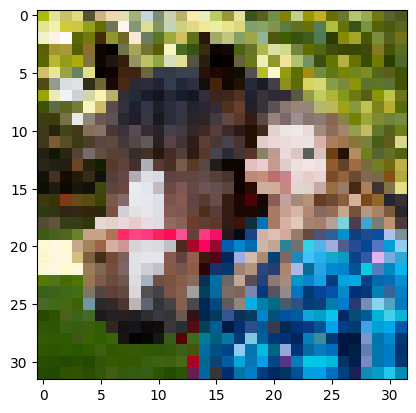

Predicted label is: horse


In [6]:
img = process_single("../test_data/distraction/horse_human.jpg")
plt.imshow(img)
plt.show()
prob = predict_single(model=model, img=transform(img), device=device)


### Plot the predicted probability for each class

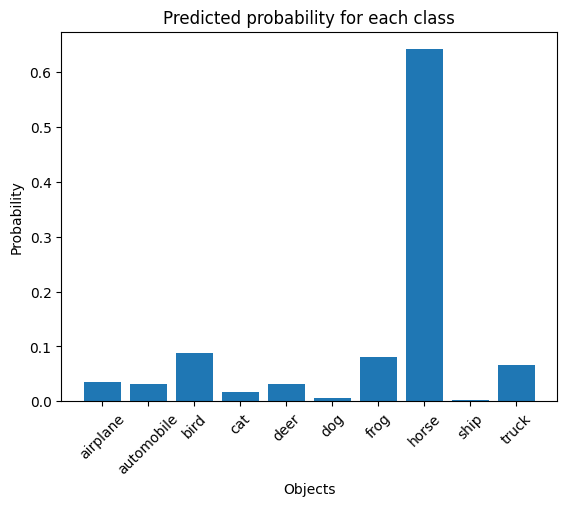

In [7]:
plt.bar(range(len(prob)), prob)
plt.xticks(range(len(prob)), classes, rotation=45)
plt.xlabel("Objects")
plt.ylabel("Probability")
plt.title("Predicted probability for each class")
plt.show()


### Multiple images prediction

In [8]:
# NOTE: defaultly all image in the folder are in one batch, change accordingly
custom_set = CustomCIFAR(imgs_path="../test_data/ship", transform=transform)
custom_loader = torch.utils.data.DataLoader(custom_set, batch_size=len(custom_set), shuffle=False)

# prediction on images in the folder
for batch_idx, imgs in enumerate(custom_loader):
    print(f"Generating predictions on batch {batch_idx + 1}")
    prob_multi = predict_multiple(model=model, imgs=imgs, device=device)


Generating predictions on batch 1
Predicted labels are: ['ship', 'ship', 'ship', 'ship', 'ship', 'ship', 'ship']
